<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/t5/661_T5_Hate_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T5 Hate Speech

This notebook will fine-tune a pretrained T5 model on the Hate Speech dataset from a White Supremacist Forum (de Gibert et al 2018). The performance of the model will serve as one of the baselines with which to compare the performances of the autoregressive models on text classification.

## Setup

In [1]:
!pip install transformers datasets pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from transformers import T5TokenizerFast, T5ForConditionalGeneration, T5ForSequenceClassification
from datasets import load_dataset, Dataset
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from time import time
import os
from sklearn.model_selection import train_test_split

In [3]:
cuda = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cuda

device(type='cuda')

In [4]:
model_size = 'base'

## Dataset

In [5]:
! git clone https://github.com/Vicomtech/hate-speech-dataset.git

Cloning into 'hate-speech-dataset'...
remote: Enumerating objects: 10785, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 10785 (delta 6), reused 0 (delta 0), pack-reused 10771 (from 1)
Receiving objects: 100% (10785/10785), 1.16 MiB | 2.63 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [6]:
!ls

hate-speech-dataset  sample_data


In [7]:
df = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')
df.head()

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


In [8]:
df['label'].value_counts()

,count
label,
noHate,9507
hate,1196
relation,168
idk/skip,73


In [9]:
relation_df = df[df['label'] == 'relation']
for i in range(10):
  with open(f'hate-speech-dataset/all_files/{relation_df.iloc[i]["file_id"]}.txt', 'r') as file:
    file_content = file.read()
    print(file_content)
    print()

You are telling me that 78 % of kids under 6 in Frankfurt are all foreigners ?

Jeeze its worst than the UK .

So far today I 've come across the words scum , slut and bitch .

All too describe my sisters .

The Indian teenager was showing the Caucasian American girl how to dissolve cow dung in water , and then use a broom to spread the filth all over the floor of their house .

Certain cultural practices just tell you volumes about a people , do n't they ?

Here is my old school picture i think it was in 1994 .

I hope such classes will be the future of all Russia

No doubt the bulk of her votes came from the ever growing chinese immigrant community around Belfast .

Scum .



In [10]:
skip_df = df[df['label'] == 'idk/skip']
for i in range(10):
  with open(f'hate-speech-dataset/all_files/{skip_df.iloc[i]["file_id"]}.txt', 'r') as file:
    file_content = file.read()
    print(file_content)
    print()

Glædelig jul !

Det er forresten en ting til Órkneyjar vil si deg , `` Tack så mycket . ''

Jag har inte själv varit med någon gång men jag har stor respekt för de som deltar .

Suomalainen totta kai !

ApÃ © ro gÃ © ant : trois jeunes soupÃ § onnÃ © s de viol https : //www.stormfront.org/forum/t809905/

BaoFeng 左眼技术 采用左眼专利技术 利用cpu和gpu有效提升画质 在线高清 shd专利技术 , 1m带宽 流畅播放720p高清视频 3d技术

Sørensen , 19 år , er født 8. april 1982 i Kolding .

Har taget en HH-eksamen på handelsskolen i Nyborg .

Medlem af DFUìs bestyrelse .

I sin fritid går Karina Sørensen på jagt med sin far , dyrker styrketræning eller nyder tilværelsen med sin kæreste .



In [11]:
df = df.loc[df['label'] != 'relation']
print(len(df))
df = df.loc[df['label'] != 'idk/skip']
print(len(df))
print(df['label'].value_counts())

10776
10703
label
noHate    9507
hate      1196
Name: count, dtype: int64


In [12]:
! ls -1 hate-speech-dataset/sampled_train | wc -l
! ls -1 hate-speech-dataset/sampled_test | wc -l

1914
478


In [13]:
! ls -1 hate-speech-dataset/all_files | wc -l

10944


In [14]:
train_df, val_test_df = train_test_split(df, test_size=0.2, stratify=df['label'])
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['label'])
print(len(train_df), len(val_df), len(test_df))

8562 1070 1071


In [15]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df.head()

,file_id,user_id,subforum_id,num_contexts,label
0,13868014_12,572043,1391,0,noHate
1,30454970_1,572043,1362,0,hate
2,30561563_1,572315,1362,0,noHate
3,13285004_1,573474,1345,0,noHate
4,13060199_2,579203,1345,0,hate


## T5 Sequence Classification

Performance of sequence classification will be used merely as a comparison to text generation.

In [16]:
tokenizer = T5TokenizerFast.from_pretrained(f't5-{model_size}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

In [17]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)
print(train_ds)
print(val_ds)
print(test_ds)

Dataset({
    features: ['file_id', 'user_id', 'subforum_id', 'num_contexts', 'label'],
    num_rows: 8562
})
Dataset({
    features: ['file_id', 'user_id', 'subforum_id', 'num_contexts', 'label'],
    num_rows: 1070
})
Dataset({
    features: ['file_id', 'user_id', 'subforum_id', 'num_contexts', 'label'],
    num_rows: 1071
})


In [18]:
label_map = {
    "hate": 1,
    "noHate": 0
}

def map_labels(data):
  data["label"] = label_map[data["label"]]
  return data

In [19]:
train_ds = train_ds.map(map_labels)
val_ds = val_ds.map(map_labels)
test_ds = test_ds.map(map_labels)

Map:   0%|          | 0/8562 [00:00<?, ? examples/s]

Map:   0%|          | 0/1070 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

In [20]:
for i, val in enumerate(train_ds):
  print(val)
  if i > 10:
    break

{'file_id': '13868014_12', 'user_id': 572043, 'subforum_id': 1391, 'num_contexts': 0, 'label': 0}
{'file_id': '30454970_1', 'user_id': 572043, 'subforum_id': 1362, 'num_contexts': 0, 'label': 1}
{'file_id': '30561563_1', 'user_id': 572315, 'subforum_id': 1362, 'num_contexts': 0, 'label': 0}
{'file_id': '13285004_1', 'user_id': 573474, 'subforum_id': 1345, 'num_contexts': 0, 'label': 0}
{'file_id': '13060199_2', 'user_id': 579203, 'subforum_id': 1345, 'num_contexts': 0, 'label': 1}
{'file_id': '14277418_4', 'user_id': 572462, 'subforum_id': 1380, 'num_contexts': 0, 'label': 0}
{'file_id': '14070837_2', 'user_id': 579266, 'subforum_id': 1383, 'num_contexts': 0, 'label': 0}
{'file_id': '30594191_1', 'user_id': 580921, 'subforum_id': 1362, 'num_contexts': 0, 'label': 0}
{'file_id': '30490748_2', 'user_id': 572668, 'subforum_id': 1359, 'num_contexts': 0, 'label': 0}
{'file_id': '13454780_1', 'user_id': 572891, 'subforum_id': 1396, 'num_contexts': 0, 'label': 0}
{'file_id': '14418116_3', 'us

In [21]:
lengths = []
for i, row in df.iterrows():
  file_id = row['file_id']
  with open(f"hate-speech-dataset/all_files/{file_id}.txt", "r") as file:
    ids = tokenizer(file.read(), truncation=True)['input_ids']
    lengths.append(len(ids))
lengths = np.array(lengths)
lengths

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


array([24, 45, 18, ..., 20, 42,  7])

In [22]:
np.percentile(lengths, 99)

102.0

Max length of 128 sufficiently captures 99% of training data

In [40]:
def tokenize_data(data):
  with open(f"hate-speech-dataset/all_files/{data['file_id']}.txt", "r") as file:
    text = file.read()
  return tokenizer(
      text,
      padding="max_length",
      truncation=True,
      max_length=128
  )

In [41]:
train_tokenized = train_ds.map(tokenize_data)
val_tokenized = val_ds.map(tokenize_data)
test_tokenized = test_ds.map(tokenize_data)

Map:   0%|          | 0/8562 [00:00<?, ? examples/s]

Map:   0%|          | 0/1070 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

In [42]:
print(train_tokenized)
print(val_tokenized)
print(test_tokenized)

Dataset({
    features: ['file_id', 'user_id', 'subforum_id', 'num_contexts', 'label', 'input_ids', 'attention_mask'],
    num_rows: 8562
})
Dataset({
    features: ['file_id', 'user_id', 'subforum_id', 'num_contexts', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1070
})
Dataset({
    features: ['file_id', 'user_id', 'subforum_id', 'num_contexts', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1071
})


In [43]:
for i, val in enumerate(train_tokenized):
  print(val)
  if i > 10:
    break

{'file_id': '13868014_12', 'user_id': 572043, 'subforum_id': 1391, 'num_contexts': 0, 'label': 0, 'input_ids': [1404, 18, 9, 18, 18219, 12, 25, 3, 6, 3, 122, 1092, 15, 3, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'file_id': '30454970_1', 'user_id': 572043, 'subforum_id': 1362, 'num_contexts': 

In [44]:
train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [45]:
unique, counts = np.unique(train_tokenized['label'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 7605, 1: 957}


In [53]:
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_tokenized, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

### Training

In [71]:
model = T5ForSequenceClassification.from_pretrained(f"t5-{model_size}", num_labels=1)
model.to(cuda)
print(model)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_feat

In [72]:
epochs = 5
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [73]:
len(train_loader)

268

In [74]:
loss_interval = len(train_loader) // 5
model.train()
t0 = time()
print("Training started")
for epoch in range(epochs):
  total_loss = 0.0
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = loss_fn(outputs.logits.squeeze(), labels.float())
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
    if i % loss_interval == (loss_interval - 1):
      print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {total_loss / 100.0:.3f}")
      total_loss = 0.0
      print(f"Time elapsed: {time()-t0:.3f}s")
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for batch in val_loader:
      input_ids = batch["input_ids"].to(cuda)
      attention_mask = batch["attention_mask"].to(cuda)
      labels = batch["label"].to(cuda)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      val_loss = loss_fn(outputs.logits.squeeze(), labels.float()).item()
      preds = torch.round(torch.sigmoid(outputs.logits))
      total += labels.size(0)
      correct += (preds.squeeze() == labels).sum().item()
    print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {correct / total:.3f}")
    print(f"Validation Loss: {val_loss:.3f}")
print("Training finished")

Training started
Epoch 1/5, Batch 53/268, Loss: 0.276
Time elapsed: 20.296s
Epoch 1/5, Batch 106/268, Loss: 0.183
Time elapsed: 40.551s
Epoch 1/5, Batch 159/268, Loss: 0.178
Time elapsed: 60.787s
Epoch 1/5, Batch 212/268, Loss: 0.179
Time elapsed: 81.022s
Epoch 1/5, Batch 265/268, Loss: 0.159
Time elapsed: 101.305s
Epoch 1/5, Validation Accuracy: 0.889
Validation Loss: 0.180
Epoch 2/5, Batch 53/268, Loss: 0.136
Time elapsed: 126.252s
Epoch 2/5, Batch 106/268, Loss: 0.121
Time elapsed: 145.979s
Epoch 2/5, Batch 159/268, Loss: 0.122
Time elapsed: 165.708s
Epoch 2/5, Batch 212/268, Loss: 0.122
Time elapsed: 185.435s
Epoch 2/5, Batch 265/268, Loss: 0.117
Time elapsed: 205.161s
Epoch 2/5, Validation Accuracy: 0.906
Validation Loss: 0.081
Epoch 3/5, Batch 53/268, Loss: 0.082
Time elapsed: 230.093s
Epoch 3/5, Batch 106/268, Loss: 0.083
Time elapsed: 249.823s
Epoch 3/5, Batch 159/268, Loss: 0.072
Time elapsed: 269.553s
Epoch 3/5, Batch 212/268, Loss: 0.074
Time elapsed: 289.286s
Epoch 3/5, Bat

### Inference

In [75]:
model.eval()
with torch.no_grad():
  all_preds = []
  all_labels = []
  for batch in test_loader:
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.round(torch.sigmoid(outputs.logits))
    all_preds.extend(preds.squeeze().tolist())
    all_labels.extend(labels.tolist())
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       951
           1       0.68      0.57      0.62       120

    accuracy                           0.92      1071
   macro avg       0.82      0.77      0.79      1071
weighted avg       0.92      0.92      0.92      1071



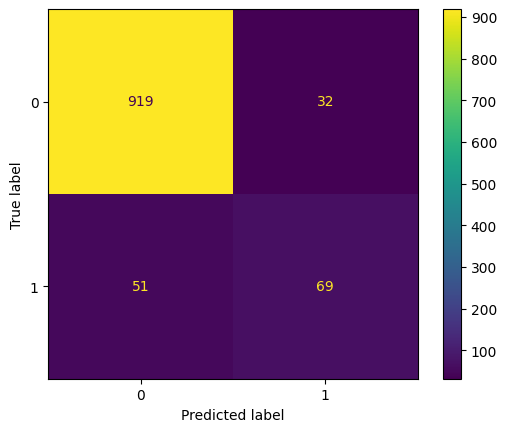

In [76]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

0.7706756046267087


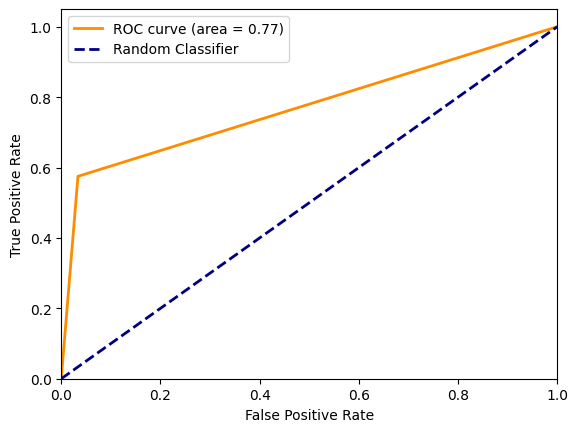

In [77]:
tpr, fpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(tpr, fpr)
print(roc_auc)
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()

> AUC will not be used in the comparison of each model; it is included only for reference.

In [78]:
torch.save(model.state_dict(), f"t5-{model_size}-hate-speech-classification.pt")

In [79]:
from google.colab import files
files.download(f"t5-{model_size}-hate-speech-classification.pt")
print("Download started")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started


## T5 Conditional Generation

Performance of conditional generation will be measured as a baseline performance, as the task more closely resembles the task of text generation for the autoregressive models.

In [80]:
torch.cuda.empty_cache()

### Tokenizer

In [81]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

In [82]:
def map_labels(data):
  if data["label"] == "noHate":
    data["hate"] = "no hate"
  else:
    data["hate"] = "hate"
  return data

In [83]:
train_ds = train_ds.map(map_labels)
val_ds = val_ds.map(map_labels)
test_ds = test_ds.map(map_labels)

Map:   0%|          | 0/8562 [00:00<?, ? examples/s]

Map:   0%|          | 0/1070 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

In [84]:
for i, val in enumerate(train_ds):
    print(val)
    if i == 10:
        break

{'file_id': '13868014_12', 'user_id': 572043, 'subforum_id': 1391, 'num_contexts': 0, 'label': 'noHate', 'hate': 'no hate'}
{'file_id': '30454970_1', 'user_id': 572043, 'subforum_id': 1362, 'num_contexts': 0, 'label': 'hate', 'hate': 'hate'}
{'file_id': '30561563_1', 'user_id': 572315, 'subforum_id': 1362, 'num_contexts': 0, 'label': 'noHate', 'hate': 'no hate'}
{'file_id': '13285004_1', 'user_id': 573474, 'subforum_id': 1345, 'num_contexts': 0, 'label': 'noHate', 'hate': 'no hate'}
{'file_id': '13060199_2', 'user_id': 579203, 'subforum_id': 1345, 'num_contexts': 0, 'label': 'hate', 'hate': 'hate'}
{'file_id': '14277418_4', 'user_id': 572462, 'subforum_id': 1380, 'num_contexts': 0, 'label': 'noHate', 'hate': 'no hate'}
{'file_id': '14070837_2', 'user_id': 579266, 'subforum_id': 1383, 'num_contexts': 0, 'label': 'noHate', 'hate': 'no hate'}
{'file_id': '30594191_1', 'user_id': 580921, 'subforum_id': 1362, 'num_contexts': 0, 'label': 'noHate', 'hate': 'no hate'}
{'file_id': '30490748_2',

In [85]:
prefix = "Determine if the following contains hateful speech: "

In [86]:
lengths = []
for i, row in df.iterrows():
  file_id = row['file_id']
  with open(f"hate-speech-dataset/all_files/{file_id}.txt", "r") as file:
    ids = tokenizer(prefix + file.read(), truncation=True)['input_ids']
    lengths.append(len(ids))
lengths = np.array(lengths)
lengths

array([34, 55, 28, ..., 30, 52, 17])

In [88]:
print(f"Shortest sequence: {lengths.min()}")
print(f"Longest sequence: {lengths.max()}")
print(f"Mean sequence length: {lengths.mean()}")

Shortest sequence: 12
Longest sequence: 583
Mean sequence length: 36.27823974586565


In [89]:
np.percentile(lengths, 99)

112.0

In [90]:
print(len(tokenizer("no hate")['input_ids']))
print(len(tokenizer("hate")['input_ids']))

3
2


In [97]:
def tokenize_data(data):
  with open(f"hate-speech-dataset/all_files/{data['file_id']}.txt", "r") as file:
    text = file.read()
  inputs = tokenizer(
      prefix + text,
      padding="max_length",
      truncation=True,
      max_length=128
  )
  labels = tokenizer(
      data["hate"],
      padding="max_length",
      truncation=True,
      max_length=3
  )
  inputs["label"] = labels["input_ids"]
  return inputs

In [98]:
train_tokenized = train_ds.map(tokenize_data)
val_tokenized = val_ds.map(tokenize_data)
test_tokenized = test_ds.map(tokenize_data)

Map:   0%|          | 0/8562 [00:00<?, ? examples/s]

Map:   0%|          | 0/1070 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

In [99]:
for i, val in enumerate(train_tokenized):
    print(val)
    if i == 10:
        break

{'file_id': '13868014_12', 'user_id': 572043, 'subforum_id': 1391, 'num_contexts': 0, 'label': [150, 5591, 1], 'hate': 'no hate', 'input_ids': [30197, 3, 99, 8, 826, 2579, 5591, 1329, 5023, 10, 1404, 18, 9, 18, 18219, 12, 25, 3, 6, 3, 122, 1092, 15, 3, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'file_id': '30454970_1', 'use

In [100]:
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [101]:
unique, counts = np.unique(train_tokenized['label'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 957, 1: 8562, 150: 7605, 5591: 8562}


In [102]:
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_tokenized, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

### Training

In [147]:
model = T5ForConditionalGeneration.from_pretrained(f"t5-{model_size}")
model.to(cuda)
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [148]:
epochs = 4
optimizer = AdamW(model.parameters(), lr=1e-4)

In [149]:
hate_map = {
    'hate': 1,
    'no hate': 0
}
hate_map

{'hate': 1, 'no hate': 0}

In [150]:
loss_interval = len(train_loader) // 5
model.train()
t0 = time()
print("Training started")
for epoch in range(epochs):
  total_loss = 0.0
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
    if i % loss_interval == (loss_interval-1):
      print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {total_loss / 100.0:.3f}")
      total_loss = 0.0
      print(f"Time elapsed: {time()-t0:.3f}s")
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    all_texts = []
    all_preds = []
    all_labels = []
    for batch in val_loader:
      input_ids = batch["input_ids"].to(cuda)
      attention_mask = batch["attention_mask"].to(cuda)
      outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=8)
      preds = [hate_map[pred] for pred in tokenizer.batch_decode(outputs, skip_special_tokens=True)]
      labels = [hate_map[label] for label in tokenizer.batch_decode(batch["label"], skip_special_tokens=True)]
      total += len(labels)
      correct += (np.array(preds) == np.array(labels)).sum()
    print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {correct / total:.3f}")

print("Training finished")

Training started
Epoch 1/4, Batch 53/268, Loss: 0.532
Time elapsed: 11.515s
Epoch 1/4, Batch 106/268, Loss: 0.069
Time elapsed: 22.927s
Epoch 1/4, Batch 159/268, Loss: 0.060
Time elapsed: 34.342s
Epoch 1/4, Batch 212/268, Loss: 0.059
Time elapsed: 45.735s
Epoch 1/4, Batch 265/268, Loss: 0.052
Time elapsed: 57.105s
Epoch 1/4, Validation Accuracy: 0.900
Epoch 2/4, Batch 53/268, Loss: 0.039
Time elapsed: 72.890s
Epoch 2/4, Batch 106/268, Loss: 0.036
Time elapsed: 83.925s
Epoch 2/4, Batch 159/268, Loss: 0.035
Time elapsed: 95.025s
Epoch 2/4, Batch 212/268, Loss: 0.036
Time elapsed: 106.031s
Epoch 2/4, Batch 265/268, Loss: 0.031
Time elapsed: 117.085s
Epoch 2/4, Validation Accuracy: 0.915
Epoch 3/4, Batch 53/268, Loss: 0.022
Time elapsed: 132.850s
Epoch 3/4, Batch 106/268, Loss: 0.019
Time elapsed: 143.887s
Epoch 3/4, Batch 159/268, Loss: 0.017
Time elapsed: 154.976s
Epoch 3/4, Batch 212/268, Loss: 0.020
Time elapsed: 166.004s
Epoch 3/4, Batch 265/268, Loss: 0.020
Time elapsed: 177.059s
Epo

### Inference

In [151]:
model.eval()
with torch.no_grad():
  all_texts = []
  all_preds = []
  all_labels = []
  for batch in test_loader:
    outputs = model.generate(input_ids=batch["input_ids"].to(cuda), attention_mask=batch["attention_mask"].to(cuda), max_length=8)
    all_texts.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))
    all_preds.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    all_labels.extend(tokenizer.batch_decode(batch["label"], skip_special_tokens=True))

In [152]:
import random
indices = random.sample(range(len(all_labels)), k=10)
for i in indices:
  print(all_texts[i])
  print("Prediction: " + all_preds[i])
  print("Truth: " + all_labels[i])
  print()

Determine if the following contains hateful speech: They have been rejected by their own government so fighting for them is not happening .
Prediction: hate
Truth: no hate

Determine if the following contains hateful speech: Yours , Rebel
Prediction: no hate
Truth: no hate

Determine if the following contains hateful speech: Foreign of course .
Prediction: no hate
Truth: no hate

Determine if the following contains hateful speech: YouTube - Odysseus ' Way by Dr. William L. Pierce ( Part 1 of 3 ) YouTube - Odysseus ' Way by Dr. William L. Pierce ( Part 2 of 3 ) YouTube - Odysseus ' Way by Dr. William L. Pierce ( Part 3 of 3 )
Prediction: no hate
Truth: no hate

Determine if the following contains hateful speech: The headline brings to mind an old joke ; I have bad news and good news for ya .
Prediction: no hate
Truth: no hate

Determine if the following contains hateful speech: They must have trapped her somehow , and sent her thru the network to Israel .
Prediction: no hate
Truth: hate

In [153]:
preds = [hate_map[pred] for pred in all_preds]
labels = [hate_map[label] for label in all_labels]

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       951
           1       0.68      0.56      0.61       120

    accuracy                           0.92      1071
   macro avg       0.81      0.76      0.79      1071
weighted avg       0.92      0.92      0.92      1071



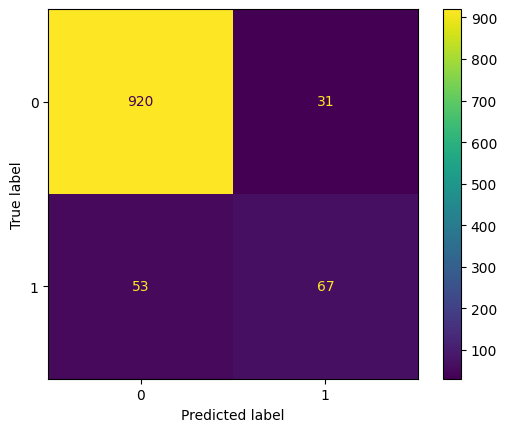

In [154]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

0.7628680336487907


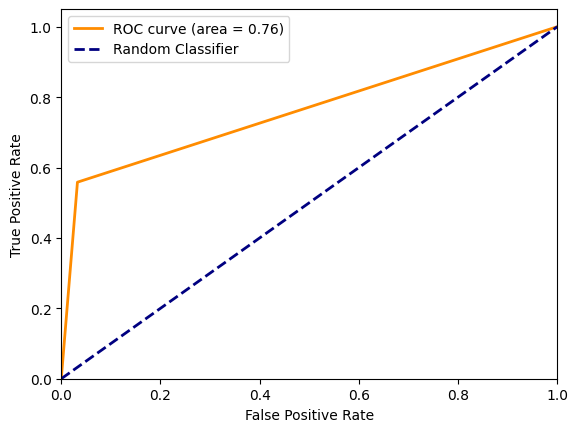

In [155]:
tpr, fpr, _ = roc_curve(labels, preds)
roc_auc = auc(tpr, fpr)
print(roc_auc)
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()

> AUC will not be used in the comparison of each model; it is included only for reference.

Interestingly, the text generation model performs slightly worse than the classification model. This may be attributed to the dataset itself, as the labeling of many examples seems subjective; a human performance comparison will be needed.

In [156]:
torch.save(model.state_dict(), f"t5-{model_size}-hate-speech-generation.pt")

In [157]:
files.download(f"t5-{model_size}-hate-speech-generation.pt")
print("Download started")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started
